In [1]:
import torch

from opal_ptx import CuModuleWrapper, kernel_transformer
from matplotlib import pyplot as plt

In [2]:
@kernel_transformer.fragment()
def mandelbrot(out: "f32", c_real: "f32", c_imag: "f32"):
    z_real: f32 = c_real
    z_imag: f32 = c_imag

    i: s32 = 0
    while i < 1000:
        z_real2: f32 = z_real * z_real
        z_imag2: f32 = z_imag * z_imag;
        
        if z_real2 + z_imag2 > f32(4.0):
            break
            
        z_imag = f32(2.0) * z_real * z_imag + c_imag
        z_real = z_real2 - z_imag2 + c_real
        
        i += 1
    out = i / 1000.0

@kernel_transformer.kernel()
def mandelbrot_kernel(buffer: "u64", width: "u32", height: "u32"):
    tidx: u32 = u32("%tid.x") + u32("%ntid.x") * u32("%ctaid.x")
    tidy: u32 = u32("%tid.y") + u32("%ntid.y") * u32("%ctaid.y")
    
    x_min: f32 = -2.0
    x_max: f32 = 1.0
    y_min: f32 = -1.5
    y_max: f32 = 1.5

    c_real: f32 = x_min + tidx * (x_max - x_min) / width
    c_imag: f32 = y_min + tidy * (y_max - y_min) / height

    buffer += (width * tidy + tidx) * 4
    buffer_global: u64   
    ptx.cvta.to._global.u64(buffer_global, buffer)

    result:f32
    mandelbrot(kernel_builder, result, c_real, c_imag)
    ptx.st._global.f32([buffer_global], result)
        

1.8535679578781128


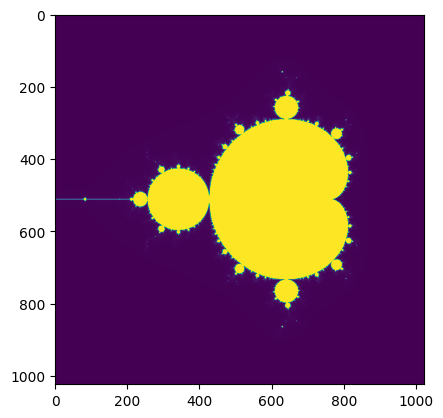

In [3]:
kernel_builder = kernel_transformer.KernelBuilder()
mandelbrot_kernel(kernel_builder)
kernel_code = kernel_builder.generate()

width, height = 1024, 1024

result = torch.zeros((width, height), dtype=torch.float32, device="cuda")

wrapper = CuModuleWrapper()
wrapper.load_ptx_code(kernel_code)

block_size_x = 32
block_size_y = 32
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()
wrapper.launch_kernel("mandelbrot_kernel", (width // block_size_x, height // block_size_y, 1), (block_size_x, block_size_y, 1), (result.data_ptr(), width, height), 0)
end_event.record()

torch.cuda.synchronize()

# Calculate the elapsed time
elapsed_time_ms = start_event.elapsed_time(end_event)
print(elapsed_time_ms)
plt.imshow(result.cpu())